<a href="https://colab.research.google.com/github/eva-butler/CS4774/blob/main/sae9fp_codeathon_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs.

You must submit the .ipynb file via UVA Collab with the following format: **yourUVAComputingID_codeathon_2.ipynb**

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

2024-11-17 17:02:29.465055: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 17:02:29.466901: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 17:02:29.576491: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 17:02:30.202847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 17:02:31.269513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

# Step 1: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
#!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

!wget -O dataset.zip "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7"

--2024-11-17 17:02:32--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.251.167.95, 142.251.16.95, 142.251.179.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.251.167.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 378.77M  15.1MB/s    in 31s     

2024-11-17 17:03:04 (12.2 MB/s) - ‘dataset.zip’ saved [397174132/397174132]



In [3]:
# Extract content
#!unzip "/content/dataset.zip?alt=media"

!unzip "dataset.zip"

Archive:  dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
from sklearn.datasets import load_files
import keras.utils 

from tqdm import tqdm # progress bar

data_dir = "dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150;
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 14286 files belonging to 18 classes.
Using 11429 files for training.


2024-11-17 17:04:46.016386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 17:04:46.016735: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [5]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

2024-11-17 17:04:48.726059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


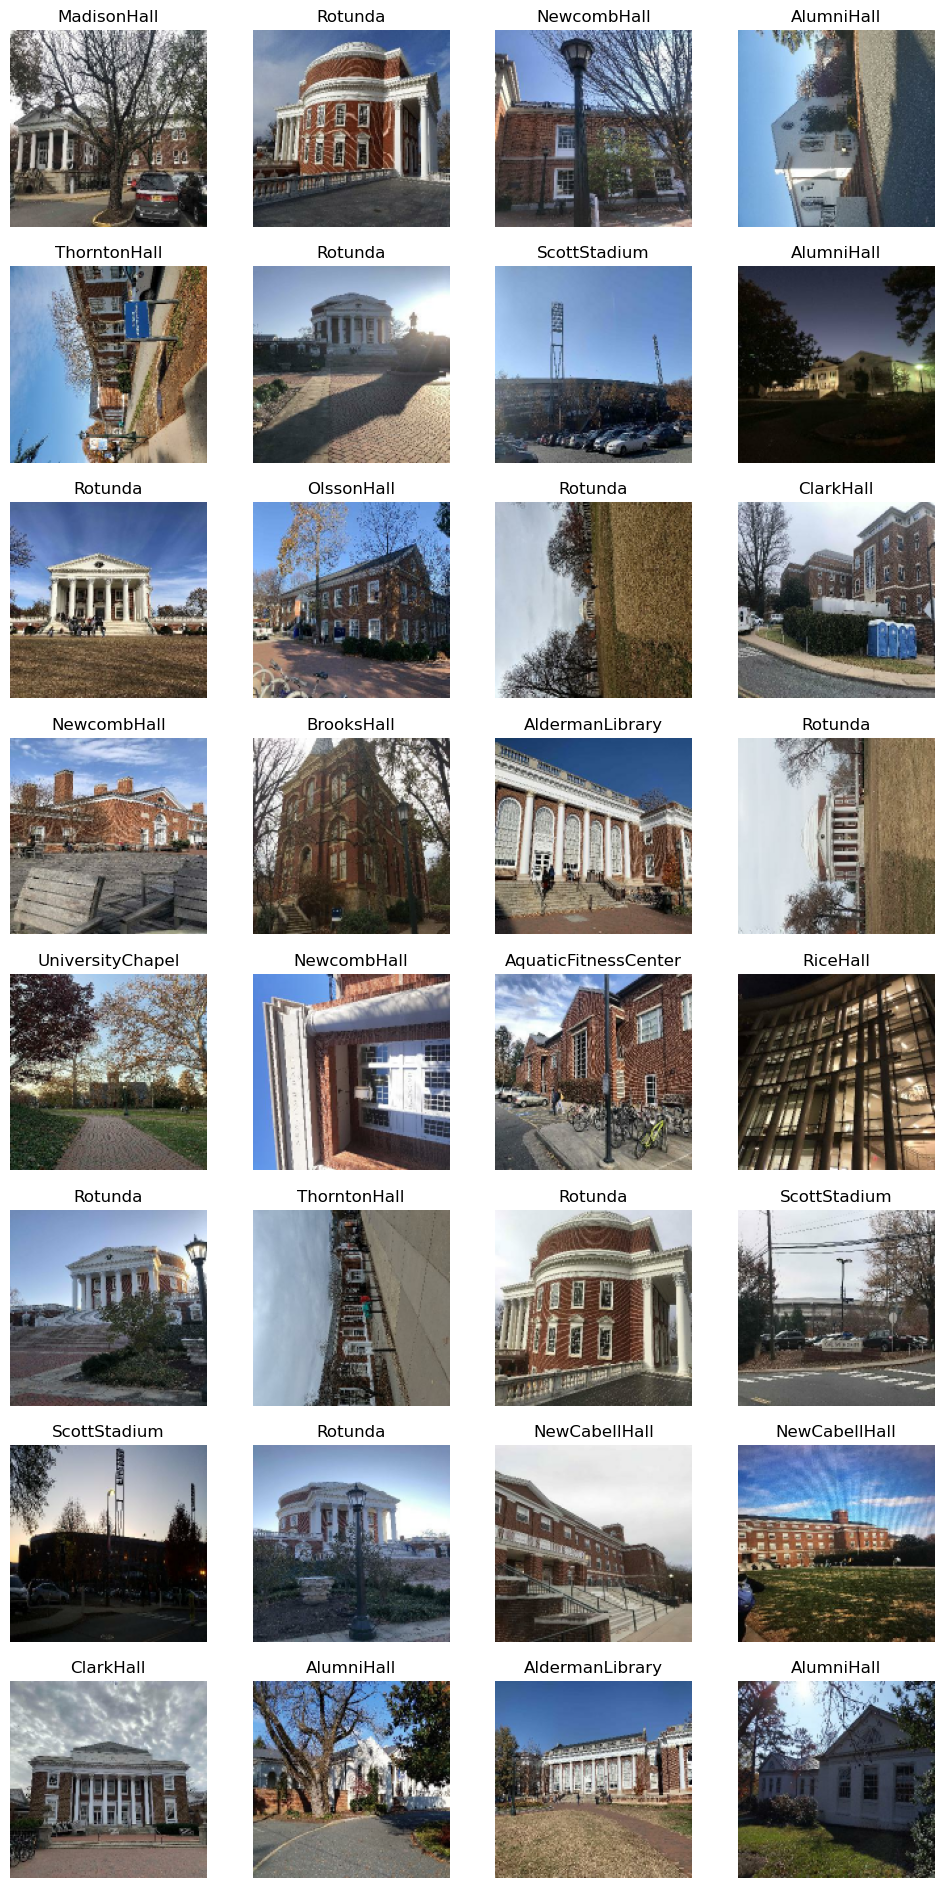

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [7]:
# YOUR CODE STARTS HERE

# Step 2: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have?
2.   Why do you decide on a certain number nodes per layer?
3.   Which activation functions do you choose?
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




In [18]:
# Your code here
myModel  = keras.models.Sequential([##TODO
    keras.layers.Conv2D(32, 4, activation='relu', input_shape=(img_height, img_width, 3), padding="same"),
    keras.layers.MaxPooling2D(2),
    
    keras.layers.Conv2D(64, 3, activation='relu', padding = "same"),  
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding = "same"),  
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.45),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation='softmax')                                                            
          

])
myModel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 150, 150, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18)             │       746,514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,946 (3.21 MB)

 Trainable params: 840,690 (3.21 MB)

 Non-trainable params: 256 (1.00 KB)

1. number of layers:
  - the model has a total of 12 layers
    - 3 convolutional layers
    - 3 max pooling layers
    - 1 batch normalization layer
    - 1 flattern layer
    - 1 dense layers
    - 1 drop out layer

2. nodes per layer
  - I chose the number of nodes per layer 32 -> 64 -> 128 because i wanted to start smaller and get bigger. it starts with fewer filters which will extract more basic features and patterns. Then in the next convolutional layer you can increase the number of filters to detect more complex difference.
3. I chose the same activation functions as the ones from class. I used relu for the convolutional layers and at the end I used softmax for the output layer to classify the different images. it helps decide where each image belongs.
4. how many params?
1,568 + 18,496 + 73,856 +  512 + 746,514 = 840946  parameters

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [19]:
myEpochs = 12
myOptimizer = "adam"
myLoss = "sparse_categorical_crossentropy"
myMetrics = ["accuracy"]
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = myModel.fit(train_ds,
                      validation_data = validation_ds,
                      epochs = myEpochs)

Epoch 1/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.2193 - loss: 4.3184 - val_accuracy: 0.0942 - val_loss: 9.8428
Epoch 2/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 55s 153ms/step - accuracy: 0.4074 - loss: 2.3209 - val_accuracy: 0.2209 - val_loss: 5.5424
Epoch 3/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 54s 151ms/step - accuracy: 0.5199 - loss: 1.9115 - val_accuracy: 0.5068 - val_loss: 1.9866
Epoch 4/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 144ms/step - accuracy: 0.6268 - loss: 1.3233 - val_accuracy: 0.3283 - val_loss: 3.1211
Epoch 5/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.6858 - loss: 1.0652 - val_accuracy: 0.4830 - val_loss: 2.2467
Epoch 6/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.7478 - loss: 0.8262 - val_accuracy: 0.5516 - val_loss: 1.9668
Epoch 7/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 55s 154ms/step - accuracy: 0.7958 - loss: 0.6506 - val_accuracy: 0.5775 - val_loss: 1.9260
Epoch 8/12
358/358 ━━━━━━━━━━━━━━━━━━━━ 54s 150ms/step - accuracy: 0.8173 - loss: 0

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)?
- Where did it makes mistake most?
- Which classes can be improved?

After looking at the following graphs, i think the model is not the best, but it is not terrrrrible. It seems like it often mistakes other buildings for Rice Hall. Weird. The overall accuracy ended up being 0.6318. Which obviously isn't great, but it took a while to get it to that point. I think if the rice hall class was imrpoved, then the model would perform significantly better.

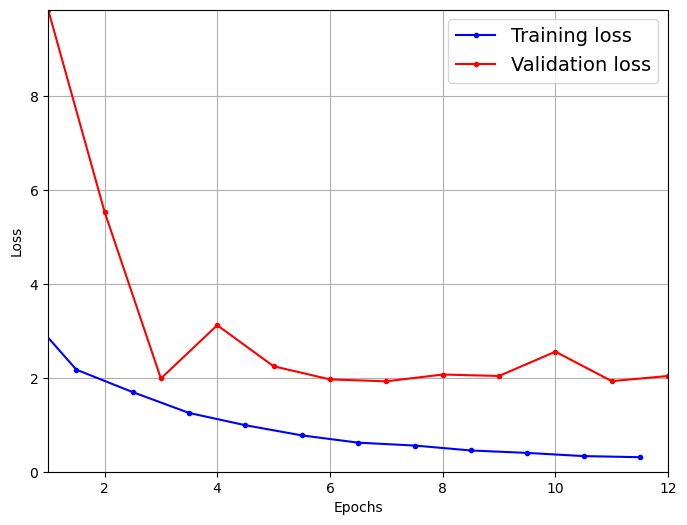

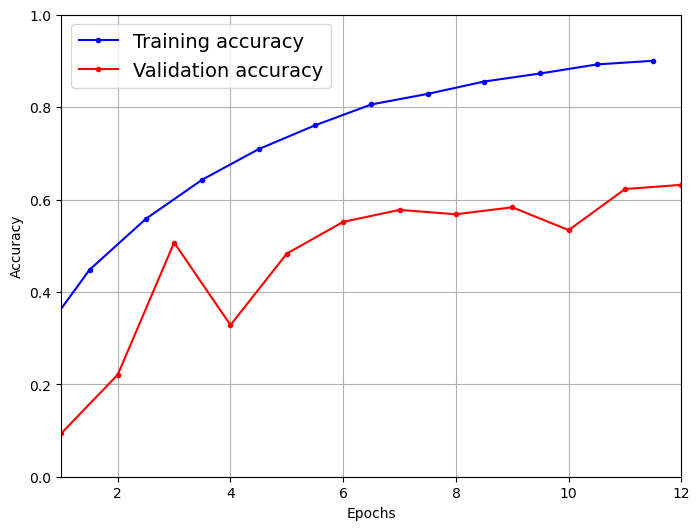

In [23]:
# Your evaluation code here


import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

def plot_loss_curves(loss, val_loss):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, len(loss), 0, max(max(loss), max(val_loss))])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

plot_loss_curves(history.history['loss'], history.history['val_loss'])


def plot_accuracy_curves(accuracy, val_accuracy):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(accuracy)) + 0.5, accuracy, "b.-", label="Training accuracy")
    plt.plot(np.arange(len(val_accuracy)) + 1, val_accuracy, "r.-", label="Validation accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, len(accuracy), 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

plot_accuracy_curves(history.history['accuracy'], history.history['val_accuracy'])

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


2024-11-17 17:44:48.347856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


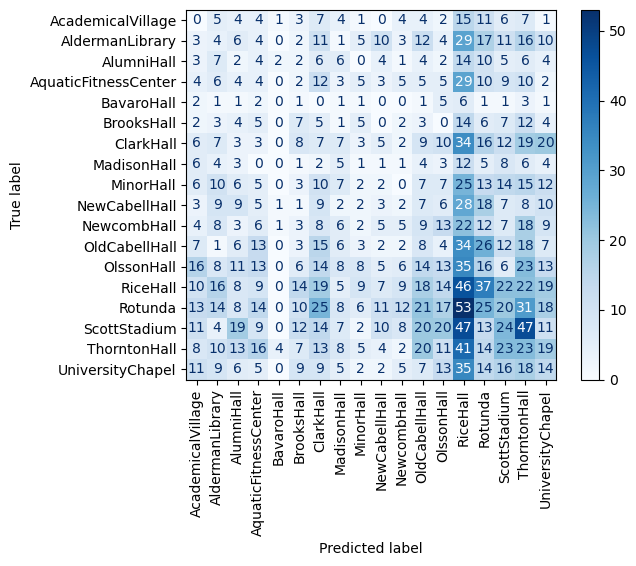

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt 
y_pred = myModel.predict(validation_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in validation_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.xticks(rotation=90)
plt.show()

it seems like the algorihtm often mistakes a lot of buildings for rice hall

# Step 3: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [33]:
# Your code here

base_model_vgg = keras.applications.VGG19(weights="imagenet", include_top=False)

x_avg = keras.layers.GlobalAveragePooling2D()(base_model_vgg.output)

output_layer = keras.layers.Dense(18, activation="softmax")(x_avg)

final_model = keras.models.Model(inputs=base_model_vgg.input, outputs=[output_layer])
final_model.summary()
print(len(final_model.layers))

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,033,618 (76.42 MB)

 Trainable params: 20,033,618 (76.42 MB)

 Non-trainable params: 0 (0.00 B)

24


1. number of layers:
  - the model has a total of 24 layers

2. nodes per layer
  - the number of nodes per layer progresses from 64 to 512. It gradually picks up on more and more details to differentiate between landmarks
3. output layer is softmax to ensure everything gets seperated into the 18 classes.
4. how many params?
20,033,618  parameters

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [36]:
# Phase 1 code here

for layer in base_model_vgg.layers:
    layer.trainable = False

final_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])


history = final_model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=5
                    )


Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.3355 - loss: 4.4475 - val_accuracy: 0.6136 - val_loss: 1.8790
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.6670 - loss: 1.4418 - val_accuracy: 0.6822 - val_loss: 1.4030
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.7452 - loss: 0.9832 - val_accuracy: 0.7242 - val_loss: 1.1931
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.7845 - loss: 0.7850 - val_accuracy: 0.7424 - val_loss: 1.1098
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.8126 - loss: 0.6690 - val_accuracy: 0.7417 - val_loss: 1.1001


In [37]:
# Phase 2 code here

for layer in final_model.layers:
    layer.trainable = True


final_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
history = final_model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=2)

Epoch 1/2
358/358 ━━━━━━━━━━━━━━━━━━━━ 1194s 3s/step - accuracy: 0.1095 - loss: 57.2899 - val_accuracy: 0.1071 - val_loss: 2.8932
Epoch 2/2
358/358 ━━━━━━━━━━━━━━━━━━━━ 1165s 3s/step - accuracy: 0.1151 - loss: 2.8096 - val_accuracy: 0.1337 - val_loss: 2.7368


90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 795ms/step


2024-11-17 20:53:50.271694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


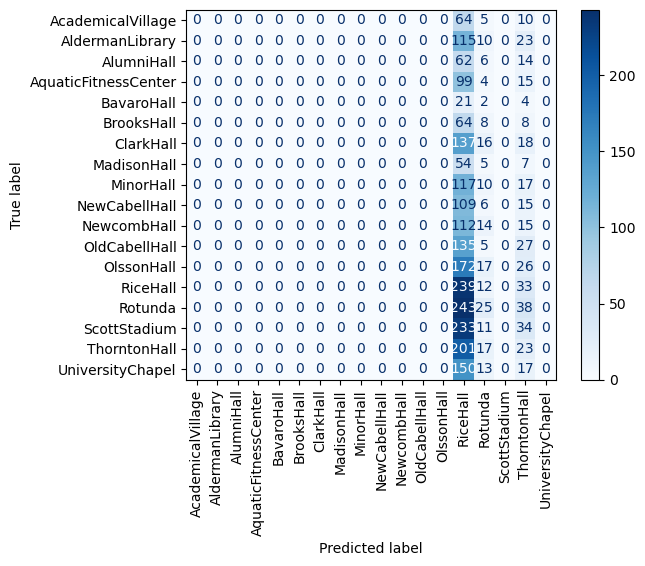

In [38]:
y_pred = final_model.predict(validation_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in validation_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.xticks(rotation=90)
plt.show()

Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall?
- In which class it improve the accuracy from the above model?
- Which class still has low performance?

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

One huge difference is that the pre trained model is taking WAYYYYY longer to run. Its harder to run it on more epochs because it would take hours upon hours to run. the phase 2 does not look good, but phase one does. It seems like there must be a lot more pictures of some buildings than others-? I am not sure though. I think this just didnt perform well because I couldn't run that many epochs. I let it run for about an hour. THere is a similar trend with this model as the one that I trained. They both mistake a lot of other buildings for rice hall. Very odd. The rotunda and thornton hall also performed poorly.

# Step 4: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

My network performed a lot better than the pretrained model. The phase 1 performed better thought with a final accuracy of 74%. The model that I trained ended with a end accuracy of 63%. The major difference between the architectures were the number of layers and the number of nodes. If I had a stronger computer or access to more tpu then i think i could have done much better. I had fun seeing how different parameters would change the accuracy of the model, however, I really did not like having to wait for these programs to run. It took away a big element of fun. 